# Goal

* Map variation between B73 and others on the phylogeny

# Setting variables

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
# Note that Nick has separate phyloseq objects for sip and the bulk soil saved
physeqDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/'

physeqFull = 'Full-Sparsity3in3'



nprocs = 20

workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
figDir = '/home/bryan/RhizCG/figures/rhizosphere_enriched/'

RhizEnrichedFile = file.path(workDir, 'l2f_B73vsGenotype.csv')

biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'
biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [3]:
%%R
library(phyloseq)
library(dplyr)
library(tidyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(foreach)
library(doParallel)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.

# Loading files

In [4]:
%%R 
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')
physeq.Full = readRDS(F)
physeq.Full.m = physeq.Full %>% sample_data
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 49 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [5]:
%%R 

physeq.plant = subset_samples(physeq.Full, Plant != "BARE")
physeq.plant.m = physeq.plant %>% sample_data
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 49 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [6]:
%%R 
# log2 fold change analysis results file
df.l2fc = read.delim(RhizEnrichedFile, sep=',')
df.l2fc %>% head(n=3)

   baseMean log2FoldChange    pvalue      padj      OTU    Rank1         Rank2
1 0.7037793      0.9585745 0.2610125        NA OTU.5899 Bacteria Acidobacteria
2 2.6175394     -0.3806323 0.5138391 0.8174481 OTU.8680 Bacteria Acidobacteria
3 1.1962488      1.0134831 0.1760730 0.5140098 OTU.2666 Bacteria Acidobacteria
       Rank3                Rank4                Rank5 Rank6 Rank7 Rank8  Plant
1      32-21 uncultured_bacterium                 <NA>  <NA>  <NA>  <NA> 75-062
2 Holophagae              Sva0725                 <NA>  <NA>  <NA>  <NA> 75-062
3 Holophagae              Sva0725 uncultured_bacterium  <NA>  <NA>  <NA> 75-062


In [7]:
%%R
#join 
p.sd = sample_data(physeq.plant)
colnames(p.sd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[37] "NAG_activity_g"      "BX_rel"              "CB_rel"             
[40] "LAP_rel"             "NAG_rel"             "NO3_ug_g"           
[43] "

In [8]:
%%R
#join 
p.sd = sample_data(physeq.plant)
LT = unique(p.sd[,c(9,13)]) 

df.l2fc = left_join(df.l2fc, LT, by = "Plant")


## Making tree plot & metadata plots separately, then combining with grid.arrange

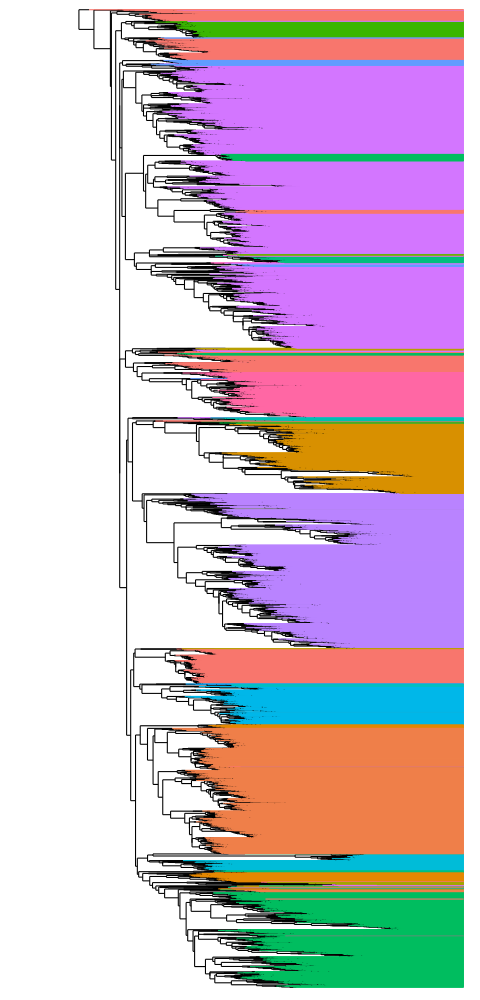

In [9]:
%%R -h 1000

plot_tree = function(physeq, color.rank="Rank2", legend.title='Phylum', 
                     plot.margin=NULL, y.expand=c(0.01,0.01),
                     legend.position='none', legend.size=4){
    # general tree plotting with ggplot
    as.Num = function(x){ x %>% as.character %>% as.numeric }
    
    # plot margin
    if(is.null(plot.margin)){
        plot.margin = unit(c(0,0,0,0), "cm")  # top, right, bottom, left        
    }

    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_inner = treeSegs$edgeDT[is.na(treeSegs$edgeDT$OTU)]
    edge_otu = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)]

    # adding taxonomy to left edges
    physeq.tax = physeq %>% tax_table %>% as.matrix %>% as.data.frame %>%
        mutate(OTU = rownames(.))
    edge_otu.df = edge_otu %>% as.matrix %>% as.data.frame %>%
        mutate(xleft = xleft %>% as.Num,
               xright = xright %>% as.Num,
               y = y %>% as.Num)
    edge_otu.df = inner_join(edge_otu.df, physeq.tax, c('OTU' = 'OTU')) %>%
        mutate(Rank2 = gsub('^__', '', Rank2),
               Rank3 = gsub('^__', '', Rank3),
               Rank4 = gsub('^__', '', Rank4),
               Rank5 = gsub('^__', '', Rank5),
               Rank6 = gsub('^__', '', Rank6),
               Rank7 = gsub('^__', '', Rank7),
               Rank8 = gsub('^__', '', Rank8)) 
    
    # adding node-metadata connector lines
    edge_otu.con = edge_otu.df %>%
                     mutate(max.xright = max(xright, na.rm=T),
                            xleft = xright,
                            xright = max.xright)
    
    # dummy facet
    edge_inner$FACET = 1
    
    # making tree plot
    p.tree = ggplot(data=edge_inner) + 
        geom_segment(aes(x=xleft, xend=xright, y=y, yend=y)) + 
        geom_segment(data=edge_otu.df, 
                     aes(x=xleft, xend=xright, y=y, yend=y)) +
        geom_segment(data=edge_otu.con,
                     aes_string(x="xleft", xend="xright", y="y", 
                                yend="y", color=color.rank)) + 
        geom_segment(data=treeSegs$vertDT, 
                     aes(x=x, xend=x, y=vmin, yend=vmax)) +
        scale_y_continuous(expand=y.expand) +
        scale_color_discrete(legend.title) +
        facet_grid(. ~ FACET) +
        theme_bw() +
        guides(colour = guide_legend(override.aes = list(size=legend.size))) +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = legend.position,
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank(),
            plot.margin = plot.margin
            )
    return(p.tree)
    }

#-- test --#
p.tree = plot_tree(physeq.plant, 
          legend.title='Phylum', 
          legend.position='none', 
          plot.margin=unit(c(0,-0.1,0,2),'cm'))
p.tree

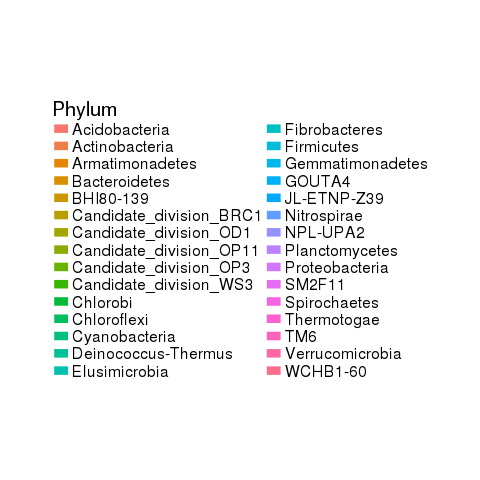

In [10]:
%%R

g_legend = function(a.gplot, text.size = 20, legend.position=c(0.5, 0.5)){ 
    # function for plotting just legend
    a.gplot = a.gplot + theme(legend.position=legend.position, 
                              text = element_text(size=text.size))
    tmp = ggplot_gtable(ggplot_build(a.gplot)) 
    leg = which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
    legend = tmp$grobs[[leg]] 
    return(legend)
    } 
                        
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [11]:
%%R 

as.Num = function(x){ x %>% as.character %>% as.numeric }

order_metadata_to_tree = function(physeq, metadata){
    # function for parsing & giving y (y.tree) value to metadata
        
    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_otu.df = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)] %>%
                as.matrix %>% 
                as.data.frame %>%
                mutate(y.tree = y %>% as.Num) %>%
                select(OTU, y.tree)
    
    # joining leaf edge and metadata
    inner_join(edge_otu.df, metadata, c('OTU' = 'OTU'))     
    }

#-- test --#
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

df.l2fc.ord = order_metadata_to_tree(physeq.plant, df.l2fc.s) 
df.l2fc.ord %>% head(n=4)

       OTU y.tree  baseMean log2FoldChange    pvalue padj  Plant DAP
1 OTU.5899   4982 0.7037793      0.9585745 0.2610125   NA 75-062  72
2 OTU.5899   4982 0.4755680      1.1390201 0.3400642   NA  ABUTH  57
3 OTU.5899   4982 0.4780952      1.9918261 0.1184747   NA  AMAPO  53
4 OTU.5899   4982 0.7977626     -0.6858935 0.3002257   NA    B97  79


## Ordering plants by DAP 

In [12]:
%%R
sample_data(physeq.Full)$Type %>% levels

[1] "BARE"      "C4_Grass"  "Dicot-Myc" "Dicot-NM"  "Legume"    "Maize"    


In [13]:
%%R
#Function is taking an input deseq object that has been mapped to tree ($y.tree), then ordering the 
#groups by another variable.  Above this is done with the clustering of incorporators.  Here this is done
# with Day of harvest

# Needed inputs
## 1) Metadata ordered to tree, in this case df.l2fc.ord
## 2) Phyloseq object, in this pase Physeq.Full is trimmed within the function to just responders
    
##Goal, order to DAP


# ordering substrates by w-unifrac distances between plants
order_plants_by_day = function(metadata, physeq, ...){
    
    ## remove bare soil controls
    ## Arange by Day and Plant, gather levels and use to order metadata
    physeq.p = physeq
        physeq.p.sd = physeq.p %>%        
            sample_data() %>%
            arrange(DAP, Plant) 
        levels(physeq.p.sd$Plant) = unique(physeq.p.sd$Plant)
        PlantOrder = levels(physeq.p.sd$Plant) 

        metadata$Plant = factor(metadata$Plant, levels=PlantOrder)
    
    return(metadata)
}

order_plants_by_type = function(metadata, physeq, ...){
    
## remove bare soil controls
## Arange by Day and Plant, gather levels and use to order metadata
 physeq.p = subset_samples(physeq.Full, Plant != "BARE") 
     sample_data(physeq.p)$Type = factor(sample_data(physeq.p)$Type, 
                                                 levels = c("Maize", "C4_Grass", 
                                                            "Dicot-Myc","Dicot-NM","Legume"))
        physeq.p.sd = physeq.p %>%        
            sample_data() %>%
            arrange(Type)

        PlantOrder = unique(physeq.p.sd$Plant)
        
        
    metadata$Plant = factor(metadata$Plant, levels=PlantOrder)
    return(metadata)
       
}
#-- test --#
#calc.wunif.dist(physeq.thresh, cores=20)
#df.l2fc.ord2 = order_plants_by_day(df.l2fc.ord, physeq.Full, cores=nprocs)
#df.l2fc.ord2 %>% head(n=4)

order_plants_by_Library = function(metadata, physeq, ...){
    
## remove bare soil controls
## Arange by Day and Plant, gather levels and use to order metadata
 physeq.p = subset_samples(physeq.Full, Plant != "BARE") 
     
        physeq.p.sd = physeq.p %>%        
            sample_data() %>%
            arrange(Library)

        PlantOrder = unique(physeq.p.sd$Plant)
        
        
    metadata$Plant = factor(metadata$Plant, levels=PlantOrder)
    return(metadata)
       
}

df.l2fc.ord2 = order_plants_by_day(df.l2fc.ord, physeq.plant, cores=nprocs)
df.l2fc.ord2 %>% head(n=4)

       OTU y.tree  baseMean log2FoldChange    pvalue padj  Plant DAP
1 OTU.5899   4982 0.7037793      0.9585745 0.2610125   NA 75-062  72
2 OTU.5899   4982 0.4755680      1.1390201 0.3400642   NA  ABUTH  57
3 OTU.5899   4982 0.4780952      1.9918261 0.1184747   NA  AMAPO  53
4 OTU.5899   4982 0.7977626     -0.6858935 0.3002257   NA    B97  79


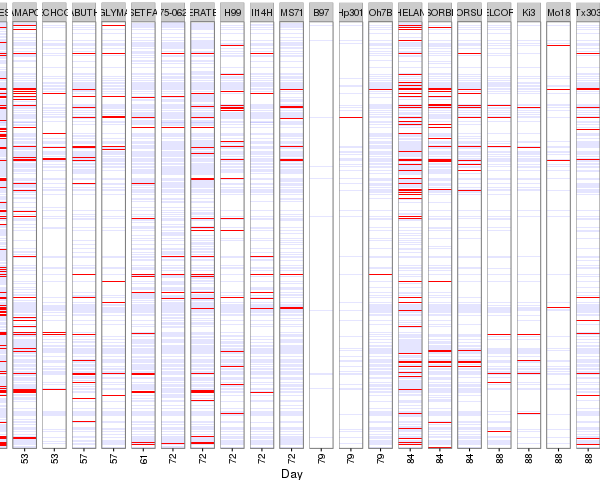

In [14]:
%%R -w 600

# function for making incorporator plot
responders_plot = function(metadata, plot.margin=NULL){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,-0.7), "cm")  # top, right, bottom, left        
    }
    
    metadata.ord = metadata %>%
        mutate(responder = padj < 0.05,
               responder.num = responder %>% as.numeric,
               Day = DAP %>% as.character)
    
    metadata.ord$Day = reorder(metadata.ord$Day, metadata.ord$Day %>% as.numeric)

    min.y = metadata.ord$y.tree %>% min(na.rm=T)
    max.y = metadata.ord$y.tree %>% max(na.rm=T)    
    
    p.responder = ggplot(metadata.ord, aes(Day, y.tree, fill=responder, alpha=responder.num)) +
        geom_tile() +
        scale_fill_manual(values=c('blue', 'red')) +
        scale_y_continuous(expand=c(0,0)) +
        facet_grid(. ~ Plant, scales='free_x') +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin    
            )   
    return(p.responder)
    }

#-- test --#
p.responders = responders_plot(df.l2fc.ord2)
p.responders

### Making OTU  abundance plots

In [15]:
%%R

B73_abund_plot_df = function(physeq, l2fc.ord){
    # creating a df for making plant soil abundance plots
    # physeq = physeq ob bulk soil samples
    physeq.m = physeq %>% sample_data
    physeq.f = prune_samples(physeq.m$Plant == 'B73', physeq)
    physeq.f.m = physeq.f %>% sample_data %>% as.data.frame
    
    ## OTU table
    tbl.otu = physeq.f %>% otu_table %>% as.data.frame
    tbl.otu$OTU = rownames(tbl.otu)
    n.col = ncol(tbl.otu)
    tbl.otu = gather(tbl.otu, 'sample', 'count', 1:(n.col-1)) %>%
        group_by(OTU) %>%
        mutate(count_byOTU_norm = count / sum(count) * 100) %>%          
        group_by(sample) %>%
        mutate(count_byComm_norm = count / sum(count) * 100) %>%
        
       ungroup
    
    
    ## joining with metadata & filtering
    df.B73 = inner_join(tbl.otu, physeq.f.m, c('sample' = 'X.sample')) 
    

        
    ## adding tree location info
    l2fc.ord.d = l2fc.ord %>%
        select(OTU, y.tree) %>%
        distinct()
    df.B73.j = left_join(l2fc.ord.d,  df.B73, c('OTU' = 'OTU')) %>%
        mutate(Day = DAP %>% as.character,
               DAP = ifelse(is.na(DAP), 1, DAP),
               count = ifelse(is.na(count), 0, count),
               count_byOTU_norm = ifelse(is.na(count_byOTU_norm), 0, count_byOTU_norm),
               count_byComm_norm = ifelse(is.na(count_byComm_norm), 0, count_byComm_norm)) 
    
    # collapse replicates
        df.B73.j = df.B73.j %>% group_by(DAP, OTU) %>% 
        mutate(count = sum(count),
               count_byOTU_norm = sum(count_byOTU_norm),
                   count_byComm_norm = sum(count_byComm_norm)) %>%
        distinct(OTU, DAP)
    return(df.B73.j)
    }

df.B73 = B73_abund_plot_df(physeq.plant, df.l2fc.ord2) 
df.B73 %>% head(n=3)

#temp = df.bulk %>% group_by(OTU) %>% summarize(sumcount = sum(count_byOTU_norm))
#temp$sumcount %>% summa

Source: local data frame [3 x 55]
Groups: DAP, OTU [3]

       OTU y.tree            sample count count_byOTU_norm count_byComm_norm
     (chr)  (dbl)             (chr) (dbl)            (dbl)             (dbl)
1 OTU.5899   4982 sample6-2.26_Nneg     9              100        0.02127054
2 OTU.8680   4978 sample6-2.26_Nneg    20              100        0.04538116
3 OTU.2666   4979 sample6-2.26_Nneg    15              100        0.03395429
Variables not shown: Library (int), Primer_Plate (int), Primer_Well_ID (fctr),
  primerFR_ID_byPlate (int), primerFR_ID_total (int), barcode_ID (int), PlotID
  (fctr), Plant (fctr), Plot (dbl), Treatment (fctr), Rep (int), DAP (int),
  Sampling (fctr), PlantSample (fctr), Type (fctr), Grass_Broad (fctr), Status
  (fctr), Subfamily (fctr), fwd_barcode (fctr), rev_barcode (fctr), Planted
  (chr), Biomass_P (dbl), SLA (dbl), Leaf_N (dbl), Leaf_C (dbl), LeafC_N (dbl),
  LNa (dbl), Plant_N (dbl), Plant_C (dbl), Plant_CN (dbl), d15N (dbl), tN_p
  (dbl), BX_ac

In [16]:
%%R
df.B73$OTU %>% unique %>% length

[1] 4981


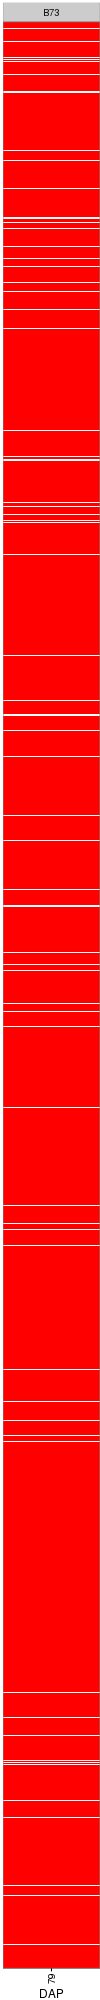

In [17]:
%%R -w 100 -h 2000
    
B73_rel_abund_plot = function(df, plot.margin=NULL){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,0), "cm")  # top, right, bottom, left        
    }
    
    df$DAP = reorder(df$DAP, df$DAP %>% as.numeric)
    df$B73 = 'B73'   
    
    p.abund = ggplot(df, aes(DAP, y.tree, fill=count_byOTU_norm)) +
        geom_tile(stat='identity') +
        scale_fill_continuous(low='white', high='red',na.value='grey80') +
        scale_y_continuous(expand=c(0,0)) +
        facet_grid(. ~ B73) +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin    
            ) 
    return(p.abund)
    }

p.rel.abund = B73_rel_abund_plot(df.B73)
p.rel.abund

## Note 
The summed counts above to display the changes over time correctly, are distorting the mean abundance plots


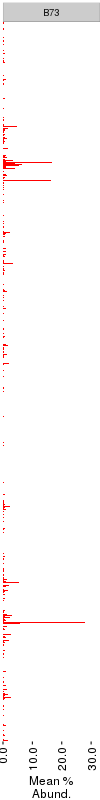

In [18]:
%%R -w 100 -h 800

B73_rel_total_abund_plot = function(df, 
                                     plot.margin=NULL, bar.width=3, 
                                     #total.counts=NULL, 
                                     round.digits=0,
                                     scale.y.log10=FALSE){
    # function for plotting abundances of taxa relative to whole community
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,0), "cm")  # top, right, bottom, left        
    }

    
    # summing counts
    df.s = df %>%
           group_by(OTU, y.tree) %>%  
           summarize(min_count_byComm_norm = min(count_byComm_norm),
                mean_count_byComm_norm = mean(count_byComm_norm),
                max_count_byComm_norm = max(count_byComm_norm)) %>% 
           ungroup()

    df.s$B73 = 'B73'
    
    # digit formating
    print.f = paste(c('%.', round.digits, 'f'), collapse='')
    
    # plotting
    p.abund = ggplot(df.s, aes(y.tree)) +
        geom_bar(aes(y=max_count_byComm_norm), stat='identity', width=bar.width, fill='green') + 
        geom_bar(aes(y=mean_count_byComm_norm), stat='identity', width=bar.width, fill='blue') +
        geom_bar(aes(y=min_count_byComm_norm), stat='identity', width=bar.width, fill='red') +
        scale_x_continuous(expand=c(0,0)) +
        facet_grid(. ~ B73) +    
        coord_flip() +
        theme_bw() +
        labs(y='Mean %\nAbund.') +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title.x = element_text(size=12),
            axis.text.x = element_text(size=12, angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            panel.border = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin    
            ) 
    if(scale.y.log10){
        p.abund = p.abund + 
            scale_y_log10(expand=c(0,0)) 
    } else {
        p.abund = p.abund +
            scale_y_continuous(expand=c(0,0), label=function(x) sprintf(print.f, round(x, round.digits))) 
    }
    return(p.abund)
    }

#-- test --#
# bulk abundance plots
df.B73 = B73_abund_plot_df(physeq.plant, df.l2fc.ord) 

                           
total_counts = df.B73 %>% 
    group_by(Day) %>%
    summarize(total_count = sum(count)) %>%
    as.data.frame      
                           
p.rel.total.abund = B73_rel_total_abund_plot(df.B73, 
                                              round.digits=1) 
p.rel.total.abund

png 
  2 


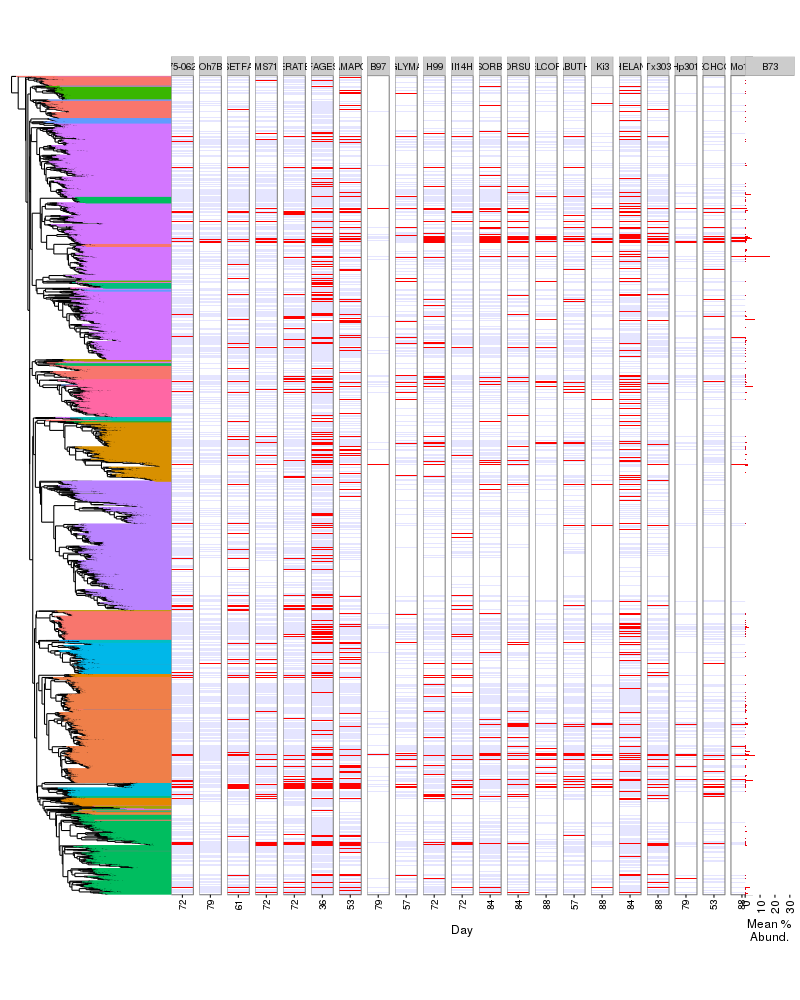

In [30]:
%%R -w 800 -h 1000
    
resize_ggplots = function(ggplot.list,
                          resize.index = length(ggplot.list),
                          widths=rep(1, length(ggplot.list))){
    # other.plots = list of plots
    stopifnot(class(ggplot.list)[1] == 'list')
    
    ## making gtables
    make_gt = function(x) ggplot_gtable(ggplot_build(x))
    gt = lapply(ggplot.list, make_gt)
        
    # resizing
    gt.len = length(gt)    
    for(i in 1:gt.len){
        if(i == resize.index){
            next
        } else {
            gt[[i]]$heights = gt[[resize.index]]$heights
        }
    }
        
    # grid.arrange params
    params.l = list('ncol' = gt.len, 'widths' = widths)

    # return list of gtables + params
    return(c(gt, params.l))
    } 

x = resize_ggplots(list(p.tree, p.responders, p.rel.total.abund), 
                   widths=c(.6,1.8,0.15))
do.call(grid.arrange, x)

outFile = '/home/bryan/RhizCG/figures/B73xGenotypeHeatmap.jpeg'
jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, x)
dev.off()

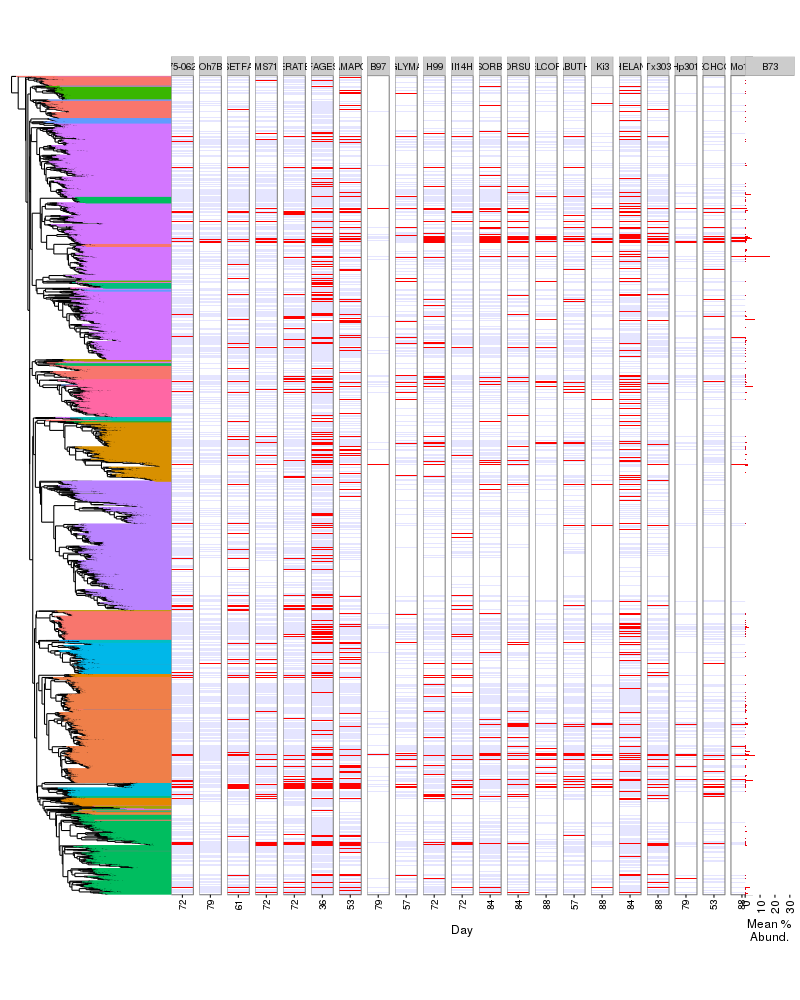

In [28]:
%%R -w 800 -h 1000
# tree plot
p.tree = plot_tree(physeq.Full, 
                   legend.title=' Phylum', 
                   y.expand=c(0.001,0.001),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full, df.l2fc.s) 
## plants by date
df.l2fc.ord = order_plants_by_Library(df.l2fc.ord, physeq.Full, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# bulk abundance plots
df.B73 = B73_abund_plot_df(physeq.plant, df.l2fc.ord) 
p.rel.abund = B73_rel_total_abund_plot(df.B73, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = B73_rel_total_abund_plot(df.B73, bar.width=2, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.total.abund),
                    widths=c(.6,1.8,0.15))
do.call(grid.arrange, gt)

In [21]:
%%R
df.l2fc.ord$OTU %>% unique %>% length

[1] 4981


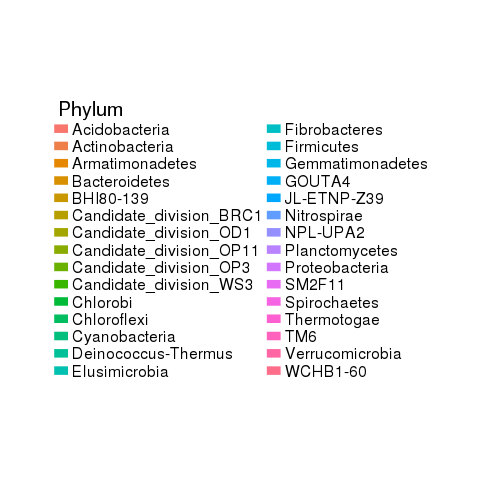

In [22]:
%%R
# tree legend
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [23]:
%%R
# saving figure
outFile = 'allPhyla_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')
jpeg(outFile, width= 9, height= 8, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()


Error in do.call(grid.arrange, gt) : object 'gt' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in do.call(grid.arrange, gt) : object 'gt' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [24]:
%%R 
# saving legend
outFile = 'allPhyla_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## full tree; just incorporators

In [25]:
%%R
# adding incorporator status to tax_table
padj.cutoff = 0.05

physeq.Full.resp = physeq.Full
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8) %>%
    group_by(OTU) %>%
    summarize(Responder = any(padj < padj.cutoff) %>% as.numeric) %>%
    ungroup() 

tax = physeq.Full.resp %>% tax_table %>% as.data.frame
tax$OTU = rownames(tax)
tax.j = left_join(tax, df.l2fc.s, c('OTU' = 'OTU')) %>% 
    mutate(Responder = ifelse(is.na(Responder), 0, Responder)) %>%
    as.data.frame() 
rownames(tax.j) = tax.j$OTU %>% as.character
tax.j$OTU = NULL

# making new phyloseq object with incorporator info
physeq.Full.resp = phyloseq(physeq.Full.resp %>% otu_table, 
                             tax.j %>% as.matrix %>% tax_table, 
                             physeq.Full.resp %>% sample_data,
                             physeq.Full.resp %>% phy_tree)
physeq.Full.resp = subset_taxa(physeq.Full.resp, Responder==1)
physeq.Full.resp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1712 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 49 sample variables ]
tax_table()   Taxonomy Table:    [ 1712 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1712 tips and 1711 internal nodes ]


In [26]:
%%R -w 800 -h 800

p.tree = plot_tree(physeq.Full.resp, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full.resp, df.l2fc.s) 
## substrates by similarity of responders
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full.resp, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# bulk abundance plots
df.B73 = B73_abund_plot_df(physeq.plant, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.B73, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = B73_rel_total_abund_plot(df.B73, bar.width=1.25, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.total.abund),
                    widths=c(0.7,1.3,0.15))
do.call(grid.arrange, gt)


Error in withVisible({ : could not find function "bulk_rel_abund_plot"


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : could not find function "bulk_rel_abund_plot"

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In left_join_impl(x, y, by$x, by$y) :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  joining factor and ch

### Simple plot: not bulk abundance data

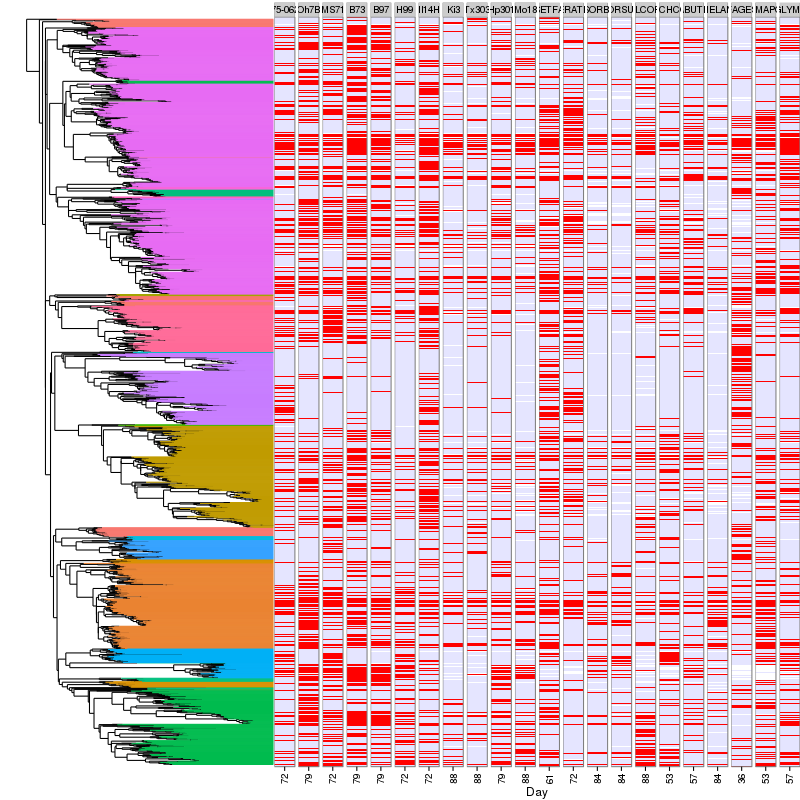

In [158]:
%%R -w 800 -h 800

p.tree = plot_tree(physeq.Full.resp, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.2,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full.resp, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full.resp, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.3))
do.call(grid.arrange, gt)

In [159]:
%%R
# saving figure
outFile = 'allPhyla-resp_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=800 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [160]:
%%R 
# saving legend
outFile = 'allPhyla-resp_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


### simple plot not bulk abundance data organized by DAP

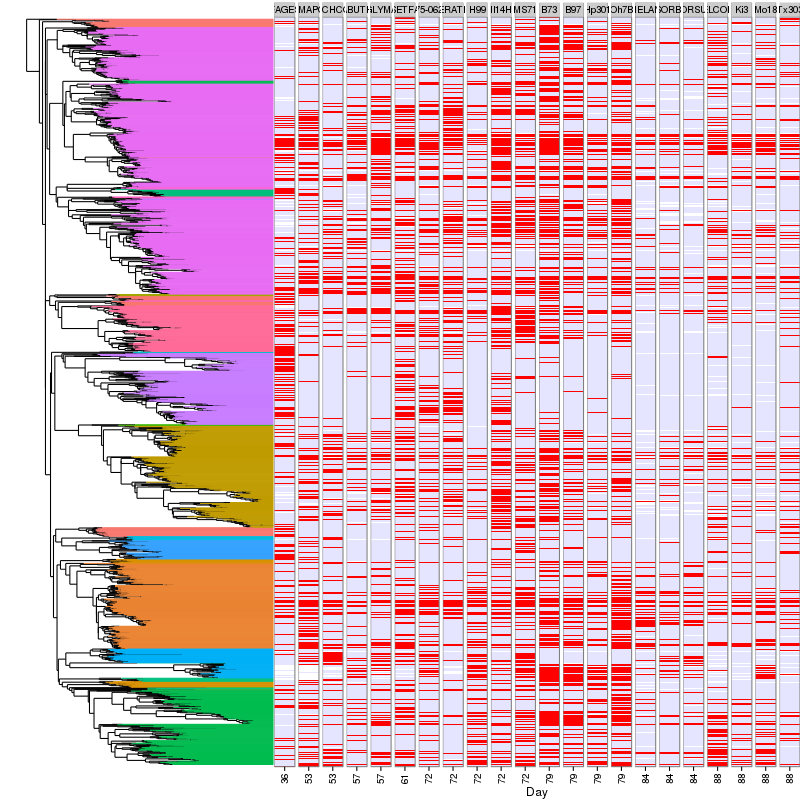

In [161]:
%%R -w 800 -h 800

p.tree = plot_tree(physeq.Full.resp, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.2,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full.resp, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_plants_by_day(df.l2fc.ord, physeq.Full.resp, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.3))
do.call(grid.arrange, gt)

In [162]:
%%R
# saving figure
outFile = 'allPhyla-resp_byDay_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=800 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [163]:
%%R 
# saving legend
outFile = 'allPhyla-resp_byDay_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


# Figures for each phylum

In [164]:
%%R
# ordering plants by full tree order (all incorporators)
full.tree.ord = df.l2fc.ord$Plant %>% levels
full.tree.ord

 [1] "FAGES"  "AMAPO"  "ECHCG"  "ABUTH"  "GLYMA"  "SETFA"  "75-062" "ERATE" 
 [9] "H99"    "Il14H"  "MS71"   "B73"    "B97"    "Hp301"  "Oh7B"   "HELAN" 
[17] "SORBI"  "SORSUD" "ELCOR"  "Ki3"    "Mo18"   "Tx303" 


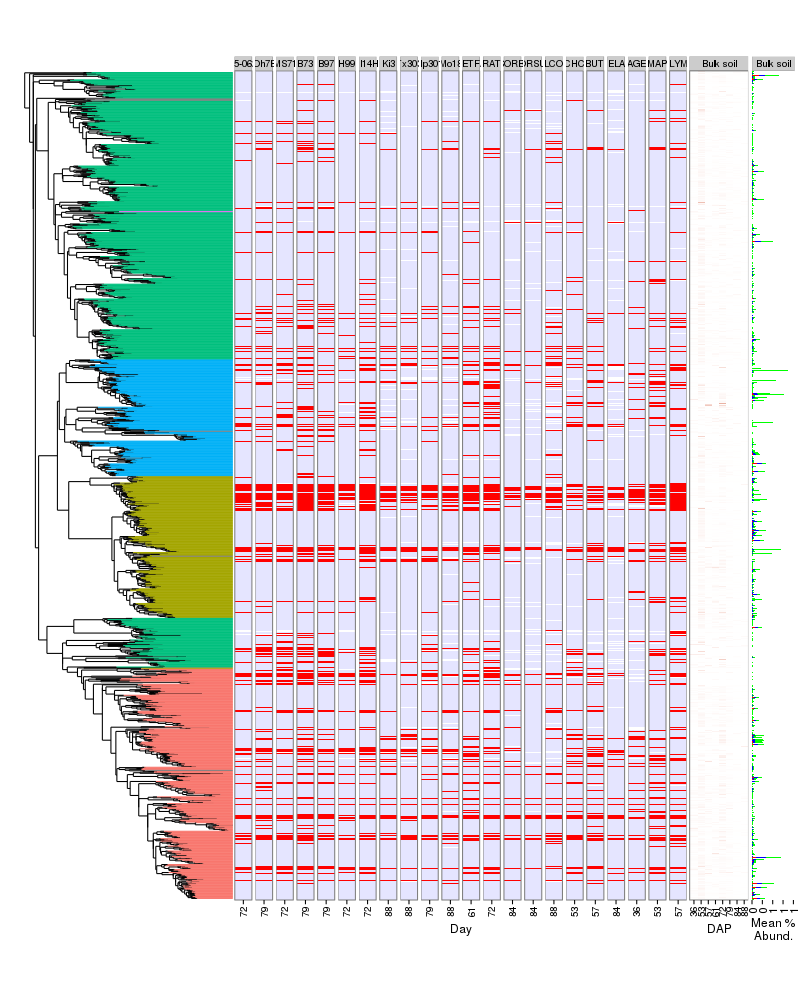

In [187]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Proteobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3,0.18,0.15))
do.call(grid.arrange, gt)

# Figures for each phylum

In [171]:
%%R
# ordering substrates by full tree order (all incorporators)
full.tree.ord = df.l2fc.ord$Plant %>% levels
full.tree.ord

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 


In [175]:
%%R
# total OTU counts for each day (for normalizing)
# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full, df.l2fc.s) 

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.Full, df.l2fc.ord) 

# total OTU counts for bulk soils
total.counts = df.bulk %>% 
    group_by(Day) %>%
    summarize(total_count = sum(count)) %>%
    as.data.frame 

total.counts

  Day total_count
1  36      345731
2  53      538309
3  57      395462
4  61      490806
5  72      460647
6  79      529997
7  84       97075
8  88       86071


In [176]:
%%R
physeq.tax = physeq.Full %>% tax_table %>% as.matrix %>% as.data.frame
physeq.tax$Rank2 %>% table %>% sort(decreasing=T)

.
         Proteobacteria          Planctomycetes          Actinobacteria 
                   1343                     789                     647 
            Chloroflexi           Acidobacteria           Bacteroidetes 
                    529                     472                     355 
        Verrucomicrobia        Gemmatimonadetes              Firmicutes 
                    228                     195                      86 
 Candidate_division_WS3         Armatimonadetes           Cyanobacteria 
                     84                      66                      54 
            Nitrospirae           Elusimicrobia                Chlorobi 
                     39                      15                      13 
Candidate_division_BRC1  Candidate_division_OD1           Fibrobacteres 
                     11                      10                      10 
                 SM2F11            Spirochaetes  Candidate_division_OP3 
                      6                       6  

## Proteobacteria

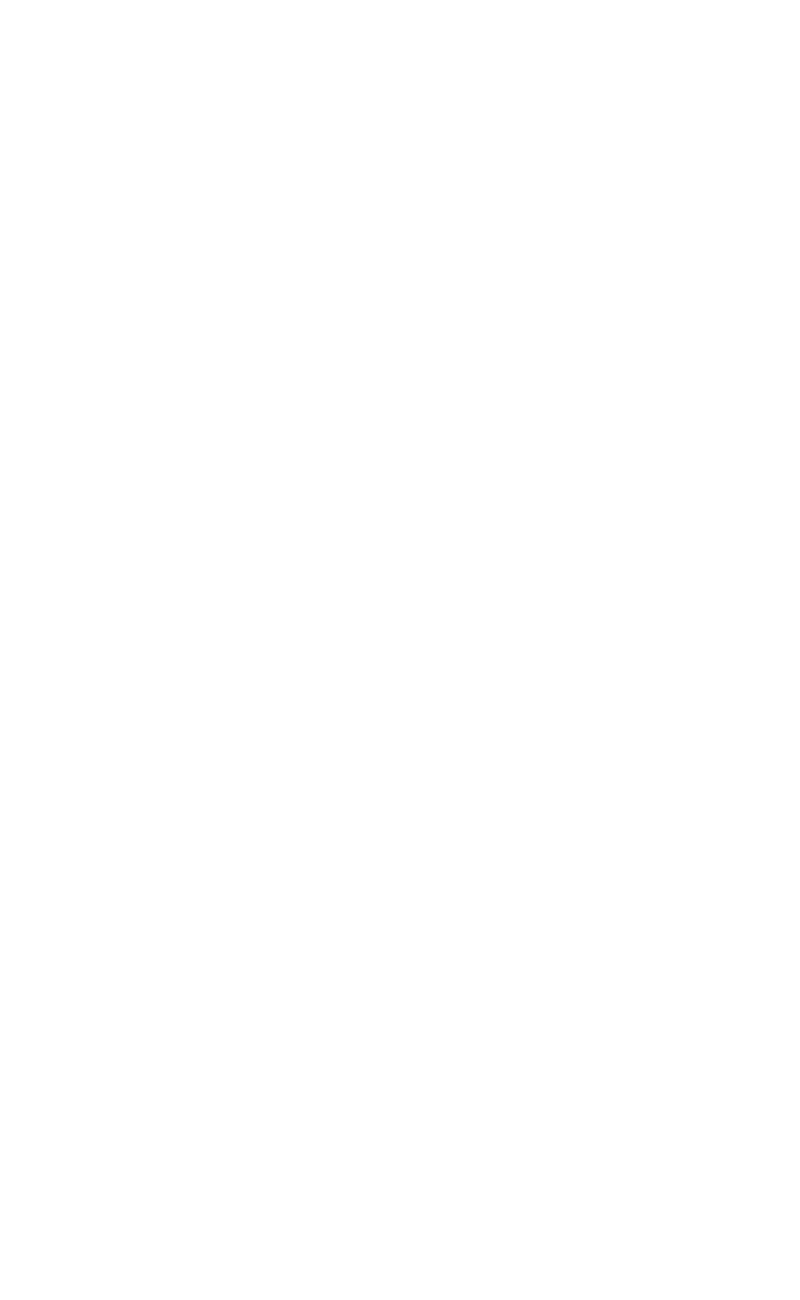

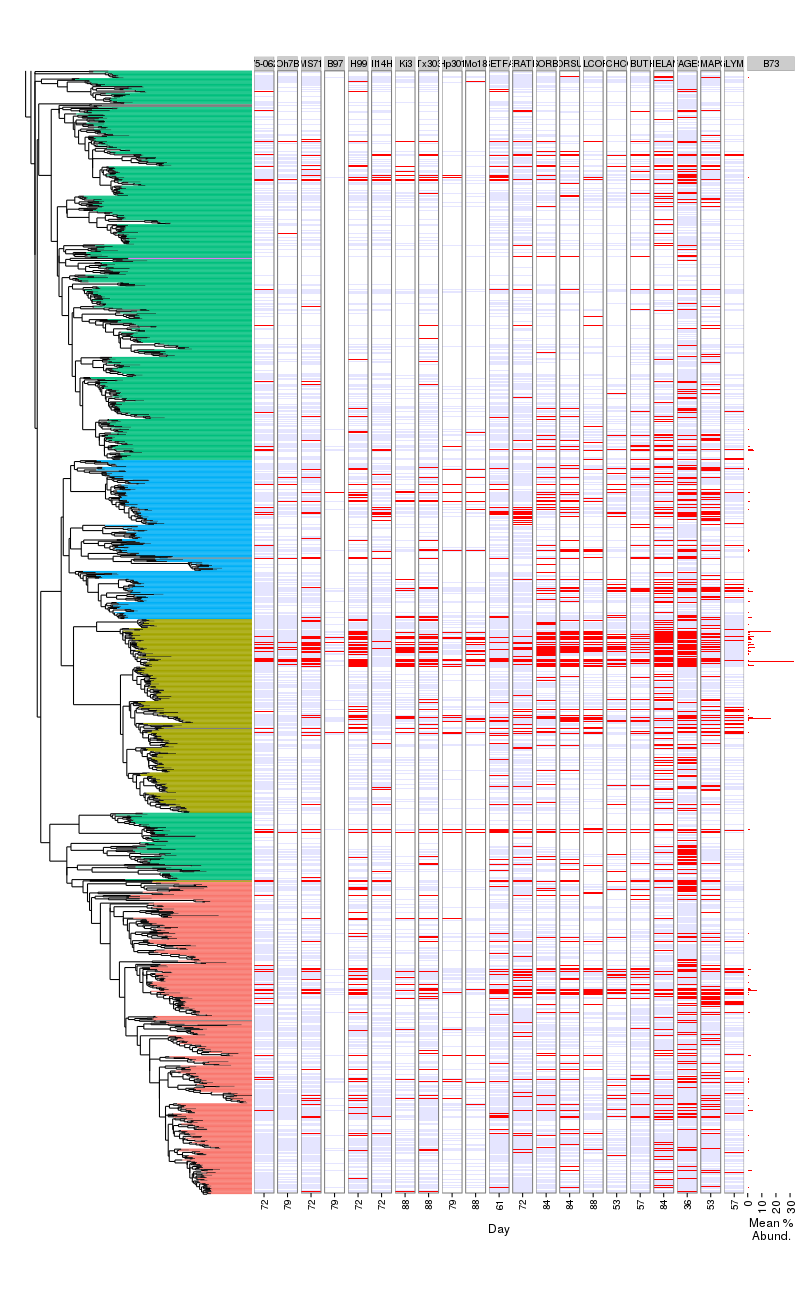

In [68]:
%%R -w 800 -h 1300

# phylum selection
phylum = "Proteobacteria"
physeq_1phy = subset_taxa(physeq.plant, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.B73 = B73_abund_plot_df(physeq.plant, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.B73, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = B73_rel_total_abund_plot(df.B73, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.total.abund),
                    widths=c(0.7,1.3,0.15))
do.call(grid.arrange, gt)

In [203]:
%%R -i figDir

#outFile = 'Proteo_sparsityCut.pdf'
#outFile = paste(c(figDir, outFile))#, collapse='/')
outFile = 'Proteo_sparsityCut.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
#outFile = file.path(figDir, 'Proteo_sparsityCut.pdf')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


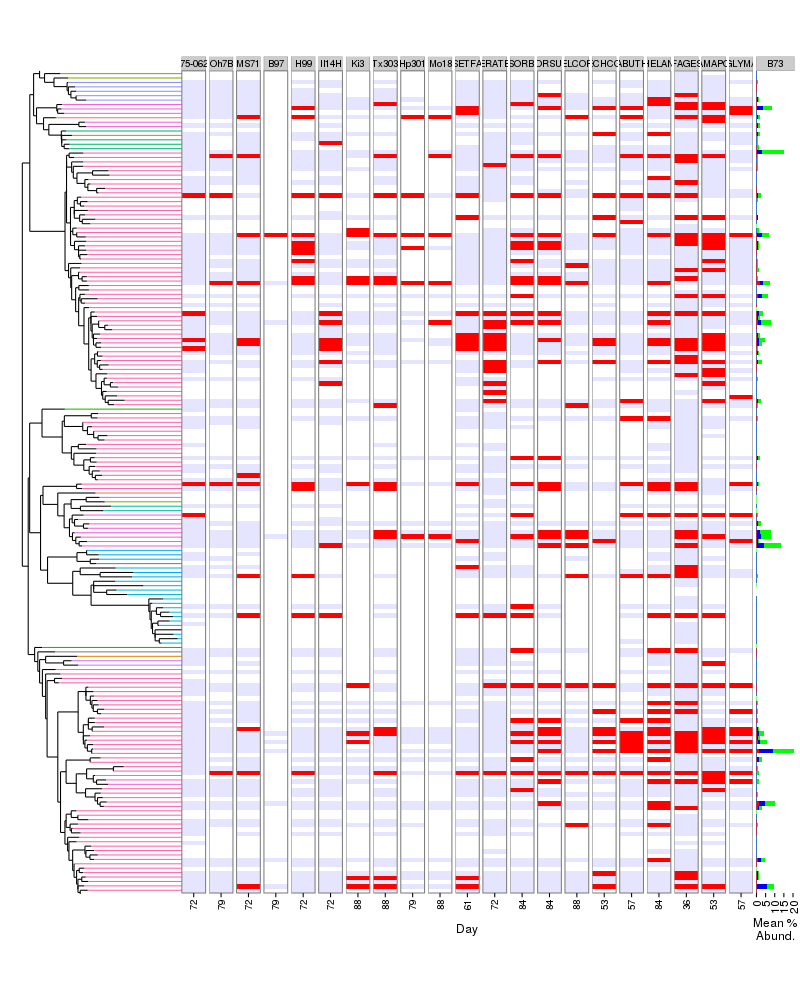

In [69]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Gammaproteobacteria"
physeq_1phy = subset_taxa(physeq.plant, Rank3==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.B73 = bulk_abund_plot_df(physeq.plant, df.l2fc.ord) 
p.rel.abund = B73_rel_abund_plot(df.B73, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = B73_rel_total_abund_plot(df.B73, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.total.abund),
                    widths=c(.6,1.8,0.15))
do.call(grid.arrange, gt)

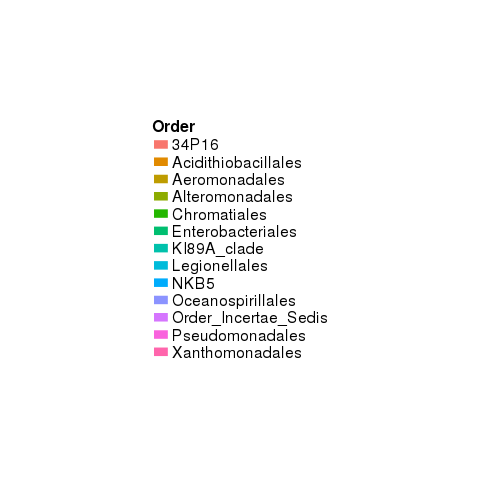

In [70]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [39]:
%%R 


outFile = 'Gamma-Proteo_sparsityCut.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')
#outFile = file.path(figDir, 'Proteo_sparsityCut.pdf')
jpeg(outFile, width=9, height=9, units = "in")
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [40]:
%%R 
# saving legend
outFile = 'Gamma-Proteo_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


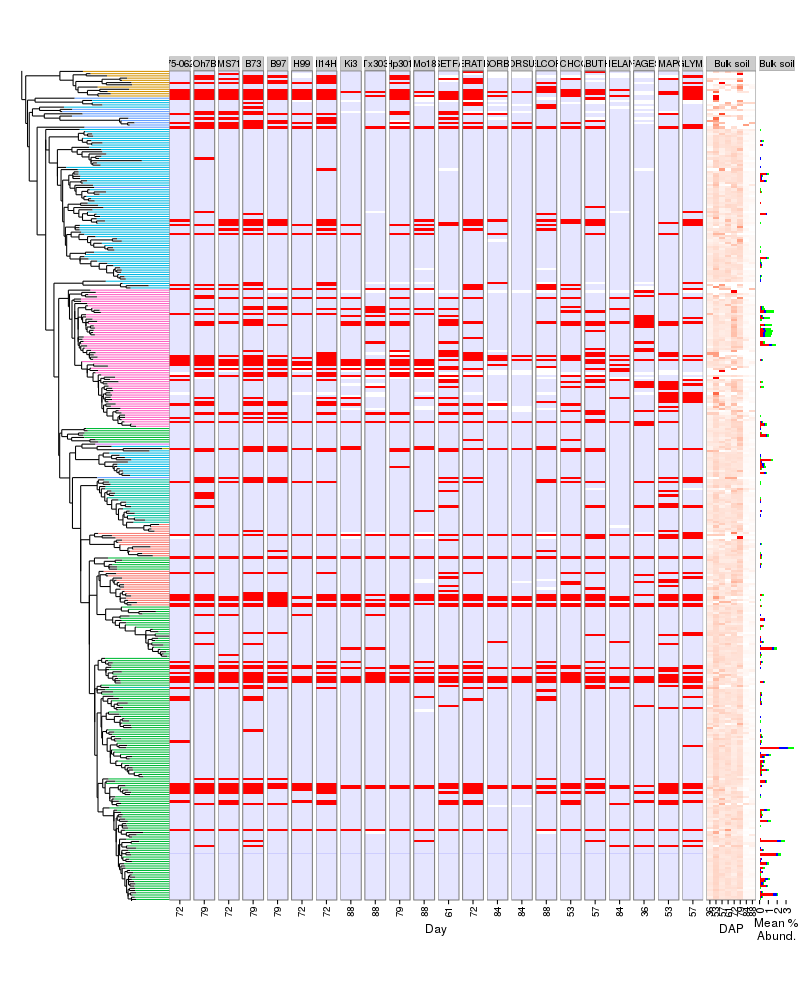

In [43]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Alphaproteobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank3==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.6,1.8,0.18,0.15))
do.call(grid.arrange, gt)

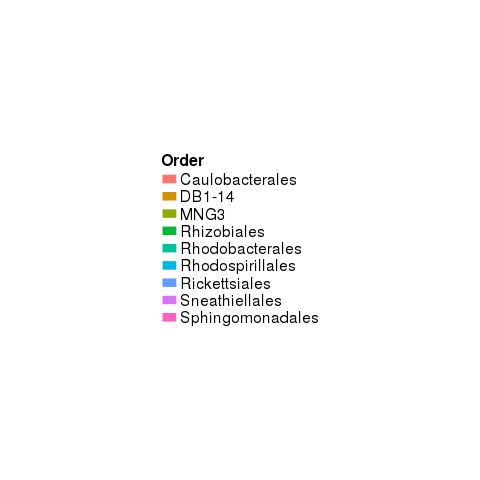

In [46]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [45]:
%%R 

outFile = 'Alpha_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [47]:
%%R 
# saving legend
outFile = 'Alpha-Proteo_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Actinobacteria

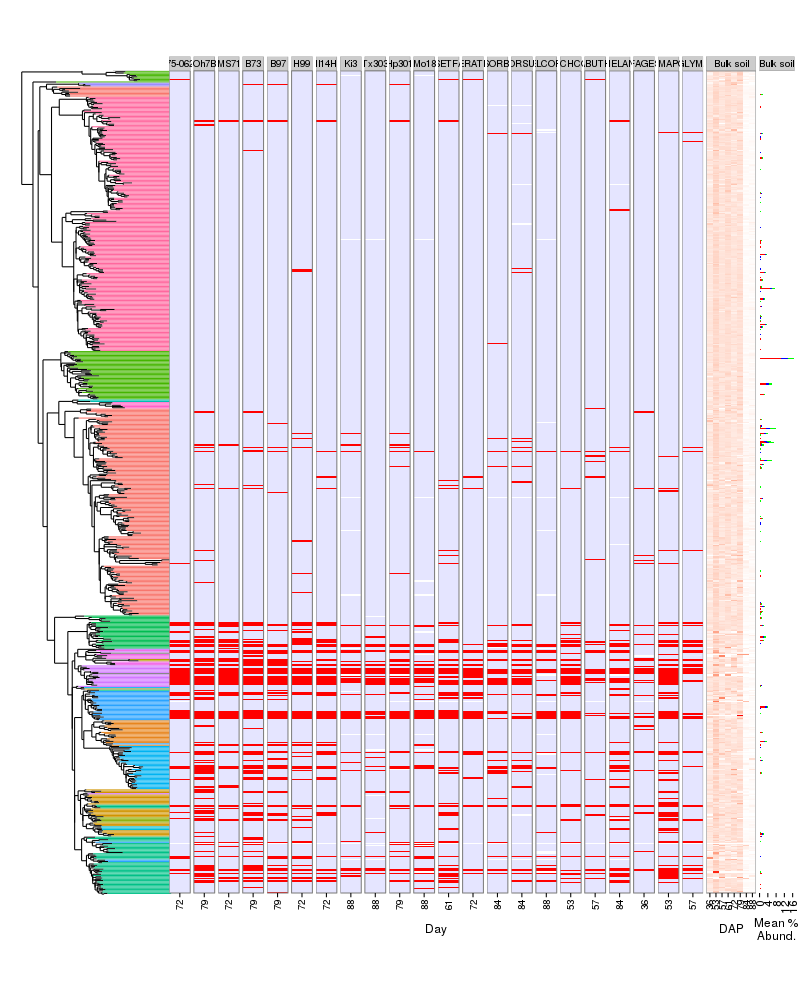

In [87]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Actinobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.6,1.8,0.18,0.15))
do.call(grid.arrange, gt)

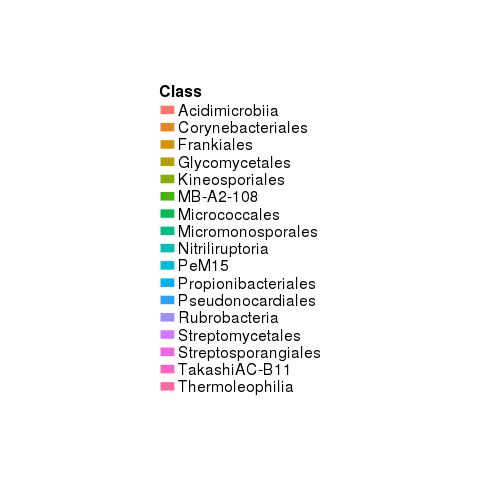

In [88]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [89]:
%%R 

outFile = 'Actino_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [90]:
%%R 
# saving legend
outFile = 'Actino_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Planctomycetes

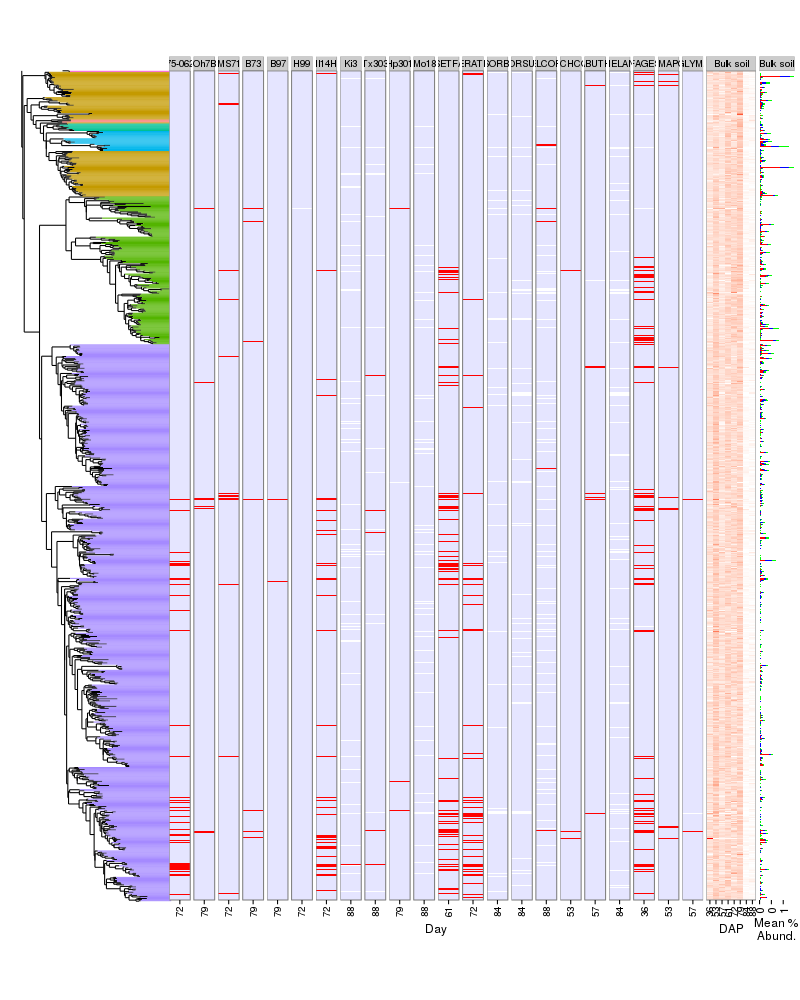

In [51]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Planctomycetes"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.6,1.8,0.18,0.15))
do.call(grid.arrange, gt)

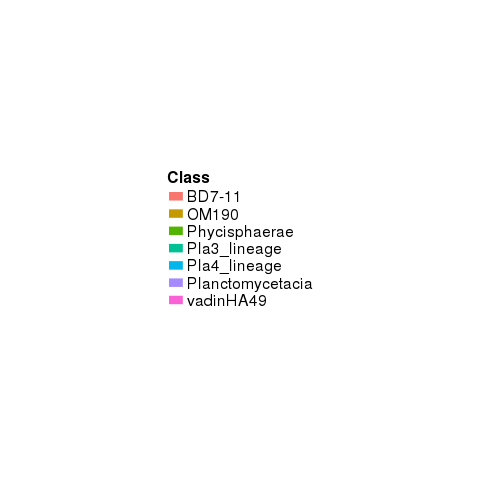

In [52]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [53]:
%%R 

outFile = 'Plancto_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [54]:
%%R 
# saving legend
outFile = 'Plancto_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Acidobacteria

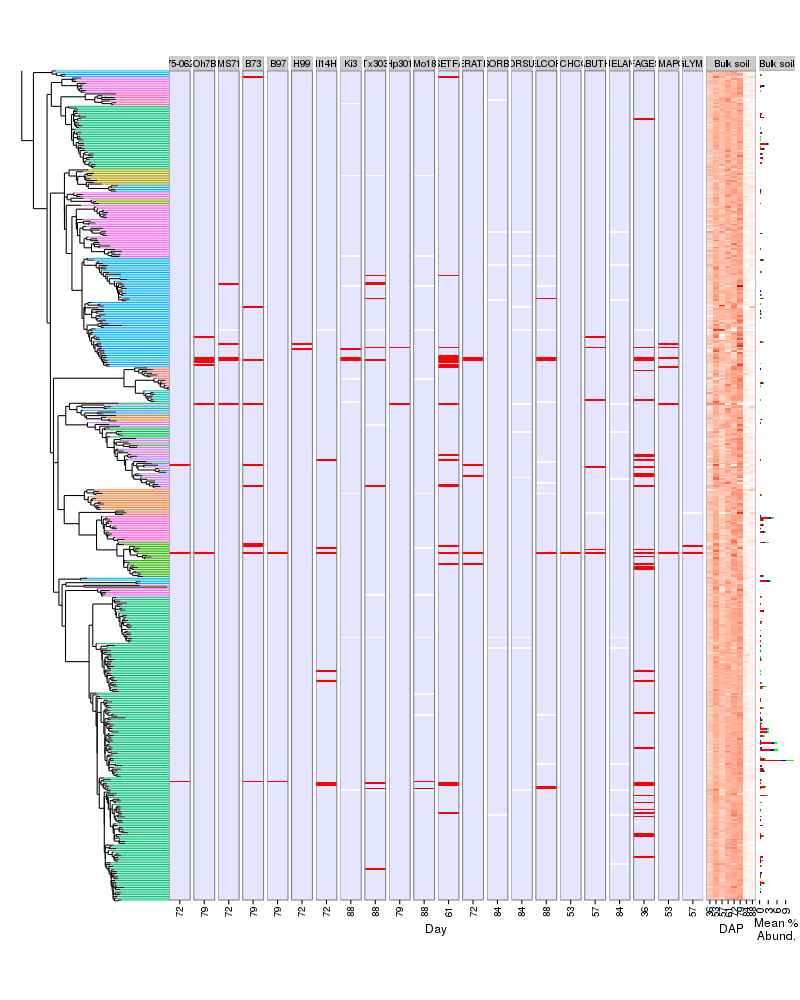

In [56]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Acidobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.6,1.8,0.18,0.15))
do.call(grid.arrange, gt)

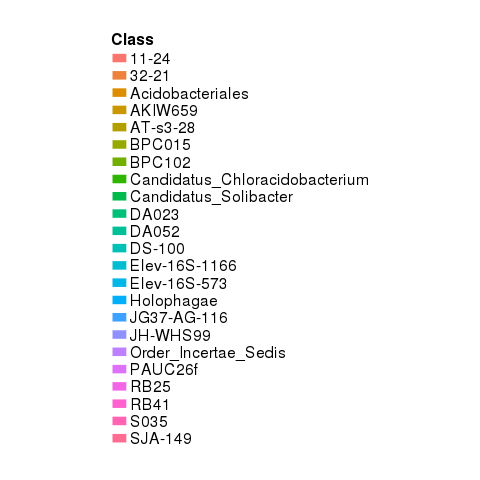

In [57]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [58]:
%%R 

outFile = 'Acido_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [59]:
%%R 
# saving legend
outFile = 'Acido_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Chloroflexi

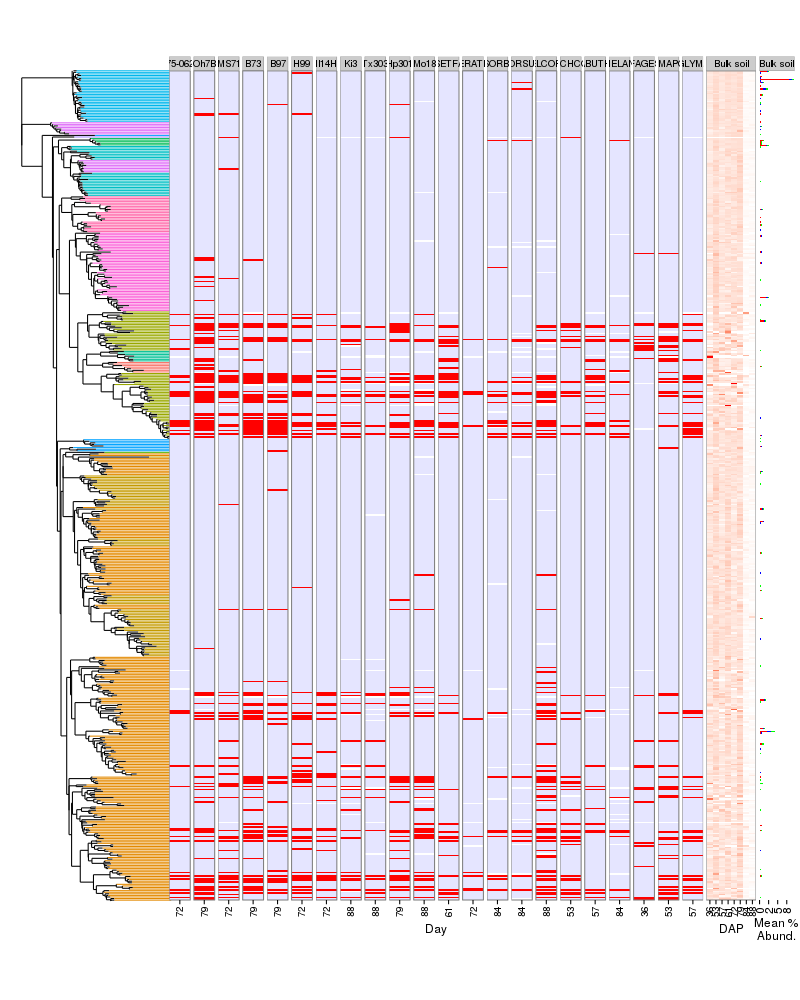

In [62]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Chloroflexi"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.6,1.8,0.18,0.15))
do.call(grid.arrange, gt)

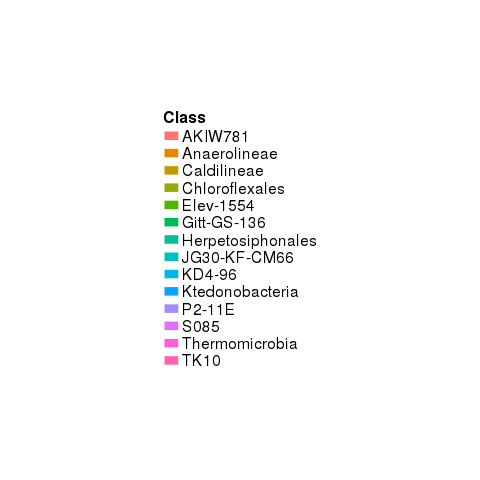

In [63]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [64]:
%%R 

outFile = 'Chloro_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [65]:
%%R 
# saving legend
outFile = 'Chloro_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Bacteroidetes

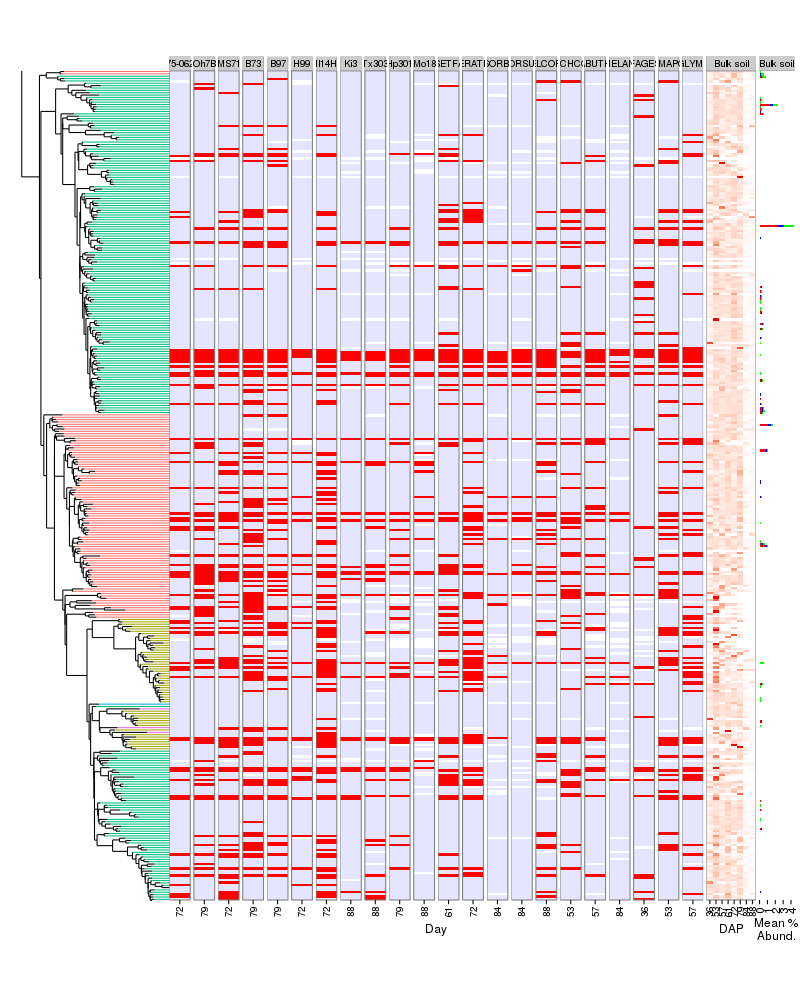

In [66]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Bacteroidetes"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.6,1.8,0.18,0.15))
do.call(grid.arrange, gt)

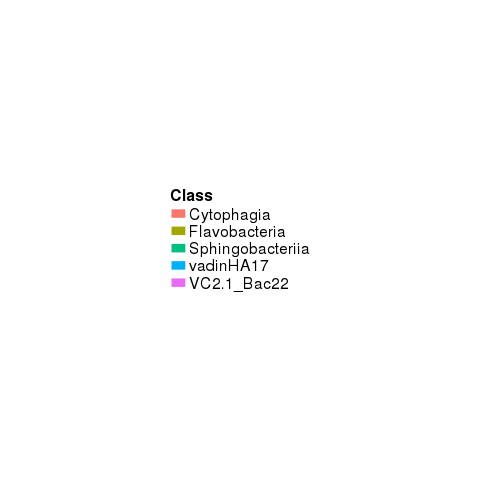

In [67]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [68]:
%%R 

outFile = 'Bacteroidetes_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [69]:
%%R 
# saving legend
outFile = 'Bacteroidetes_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Verrucomicrobia

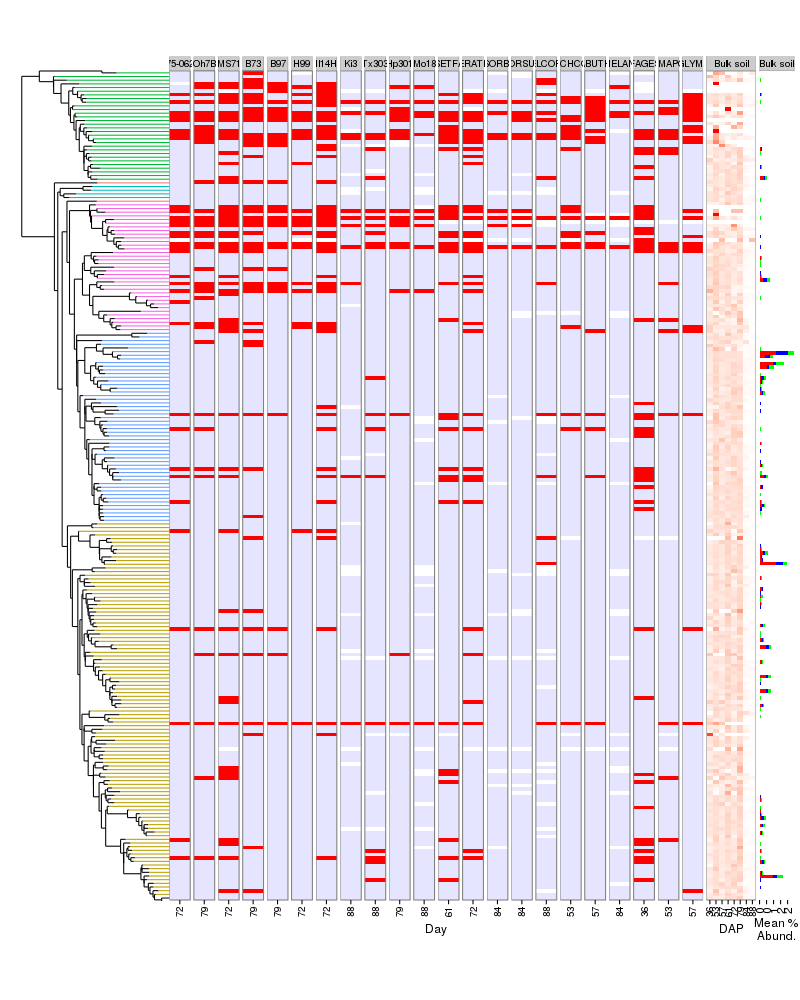

In [70]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Verrucomicrobia"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.6,1.8,0.18,0.15))
do.call(grid.arrange, gt)

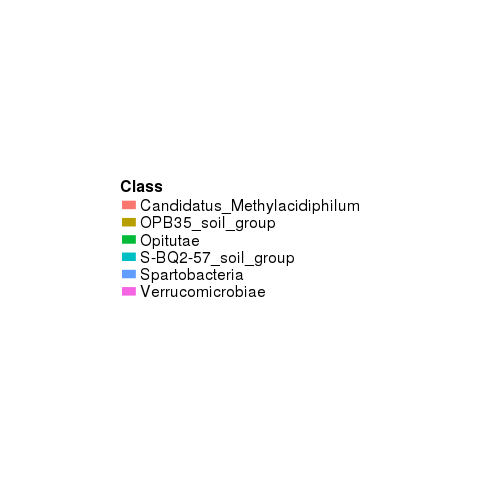

In [71]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [72]:
%%R 

outFile = 'Verruco_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [73]:
%%R 
# saving legend
outFile = 'Verruco_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Firmicutes 

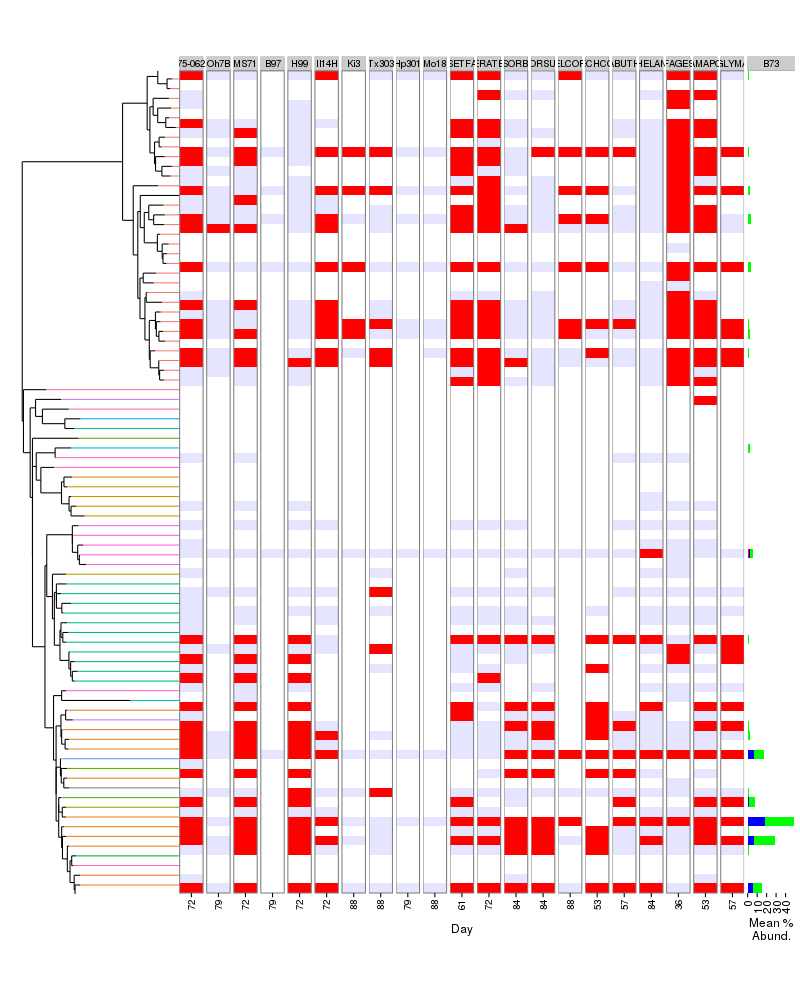

In [67]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Firmicutes"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank6',
                   legend.title='Family',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.B73 = bulk_abund_plot_df(physeq.plant, df.l2fc.ord) 
p.rel.abund = B73_rel_abund_plot(df.B73, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = B73_rel_total_abund_plot(df.B73, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.total.abund),
                    widths=c(.6,1.8,0.18))
do.call(grid.arrange, gt)

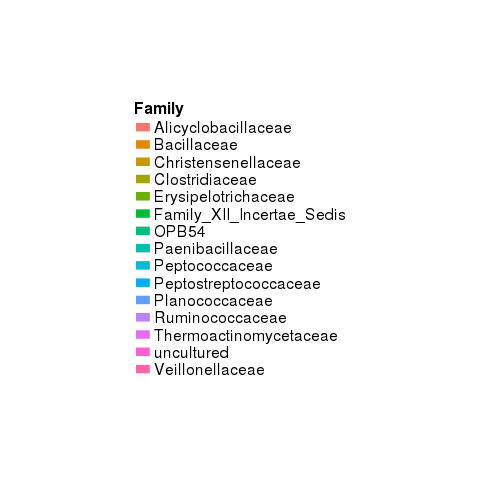

In [63]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [80]:
%%R 

outFile = 'Firmicutes_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [81]:
%%R 
# saving legend
outFile = 'Firmicutes_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


In [104]:
%%R
TT = physeq.Full %>% tax_table %>% data.frame
colnames(TT)
TT[row.names(TT) == "OTU.1001",]

            Rank1      Rank2           Rank3              Rank4
OTU.1001 Bacteria Firmicutes Erysipelotrichi Erysipelotrichales
                       Rank5          Rank6                Rank7 Rank8
OTU.1001 Erysipelotrichaceae Asteroleplasma uncultured_bacterium  <NA>


In [65]:
%%R
df.family = df.l2fc[!is.na(df.l2fc$Rank5),] 

Pb_sel = df.family$Rank5 == "Paenibacillaceae"

Pb = df.family[Pb_sel,] %>% arrange(padj)
Pb[,c("Rank5", "Rank6", "padj")]

               Rank5         Rank6         padj
1   Paenibacillaceae Paenibacillus 4.037860e-07
2   Paenibacillaceae Paenibacillus 9.144410e-06
3   Paenibacillaceae Paenibacillus 1.574015e-05
4   Paenibacillaceae Paenibacillus 2.041233e-04
5   Paenibacillaceae Paenibacillus 2.323458e-04
6   Paenibacillaceae Paenibacillus 2.414146e-04
7   Paenibacillaceae Paenibacillus 7.713637e-04
8   Paenibacillaceae Paenibacillus 2.298171e-03
9   Paenibacillaceae Paenibacillus 2.664643e-03
10  Paenibacillaceae Paenibacillus 2.985790e-03
11  Paenibacillaceae Paenibacillus 4.117770e-03
12  Paenibacillaceae Paenibacillus 4.859910e-03
13  Paenibacillaceae Paenibacillus 4.916190e-03
14  Paenibacillaceae Paenibacillus 7.227964e-03
15  Paenibacillaceae Paenibacillus 7.364661e-03
16  Paenibacillaceae Paenibacillus 9.731517e-03
17  Paenibacillaceae Paenibacillus 1.181513e-02
18  Paenibacillaceae Paenibacillus 1.413334e-02
19  Paenibacillaceae Paenibacillus 1.630993e-02
20  Paenibacillaceae Paenibacillus 1.760

## Gemmatimonadetes

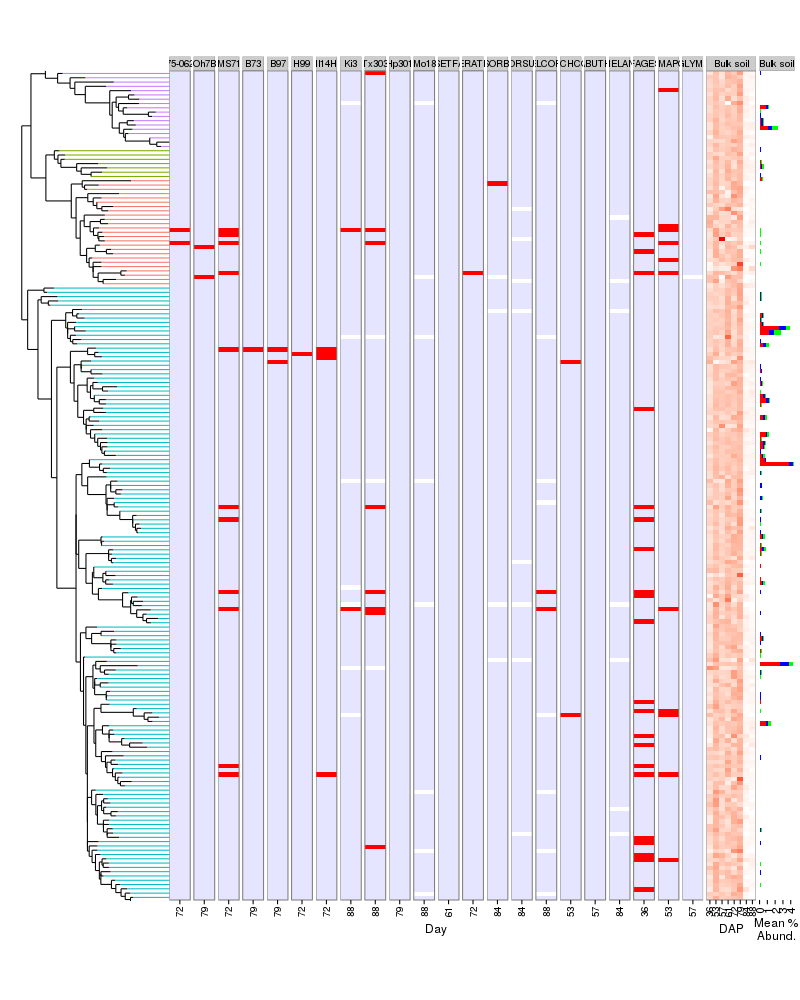

In [83]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Gemmatimonadetes"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.6,1.8,0.18,0.15))
do.call(grid.arrange, gt)

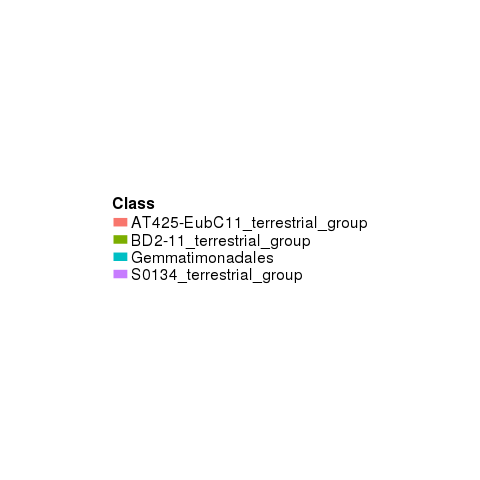

In [84]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [85]:
%%R 

outFile = 'Gemma_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [86]:
%%R 
# saving legend
outFile = 'Gemma_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


In [247]:
%%R -i figDir

outFile = 'Gemma_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 
